In [341]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.integrate import odeint
import lmfit

In [342]:
sns.set()
%matplotlib inline

In [343]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [344]:
%autoreload 2

In [345]:
from sir_models.seir_two_stain import SEIRTwoStain
from sir_models.utils import stepwise, get_quarantine_multiplier_value

# Load data

In [346]:
df = pd.read_csv('data/data.csv', sep=';')

In [347]:
df.columns = ['date', 'region', 'total_infected', 'total_recovered', 'total_dead', 'deaths_per_day', 'infected_per_day', 'recovered_per_day']
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')

df['infected'] = df['total_infected'] - df['total_recovered'] - df['total_dead']

In [348]:
df = df[df.region == 'Москва'].reset_index()
#df = df.groupby('date').sum().reset_index()

In [349]:
df.head()

,index,date,region,total_infected,total_recovered,total_dead,deaths_per_day,infected_per_day,recovered_per_day,infected
0,40,2020-03-12,Москва,21,0,0,0,21,0,21
1,122,2020-03-13,Москва,26,0,0,0,5,0,26
2,204,2020-03-14,Москва,35,0,0,0,9,0,35
3,286,2020-03-15,Москва,35,1,0,0,0,1,34
4,368,2020-03-16,Москва,53,1,0,0,18,0,52


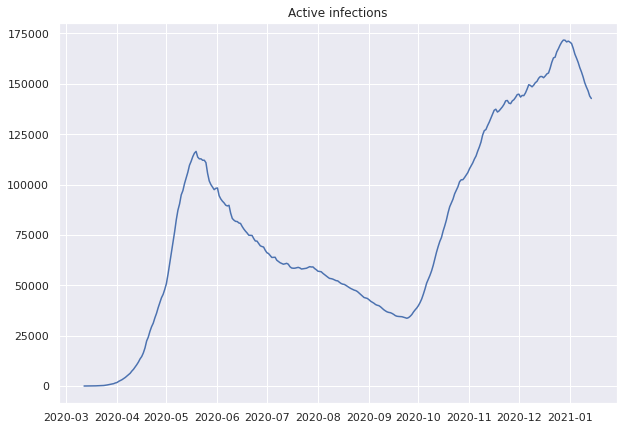

In [350]:
plt.figure(figsize=(10,7))
plt.plot(df.date, df.infected)
plt.title("Active infections")
plt.show()

# Model

In [351]:
train_subset = df[(df.date <= '2020-12-31')]

In [352]:
model = SEIRTwoStain()
model.fit(train_subset)

(S, E1, I1, E2, I2, R, D), history = model.predict_train()

result = model.fit_result_
result

In [353]:
train_subset.iloc[0]

index                                 40
date                 2020-03-12 00:00:00
region                            Москва
total_infected                        21
total_recovered                        0
total_dead                             0
deaths_per_day                         0
infected_per_day                      21
recovered_per_day                      0
infected                              21
Name: 0, dtype: object

In [354]:
I1[0], I2[0]

(1.0, 0.0)

In [355]:
I2

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

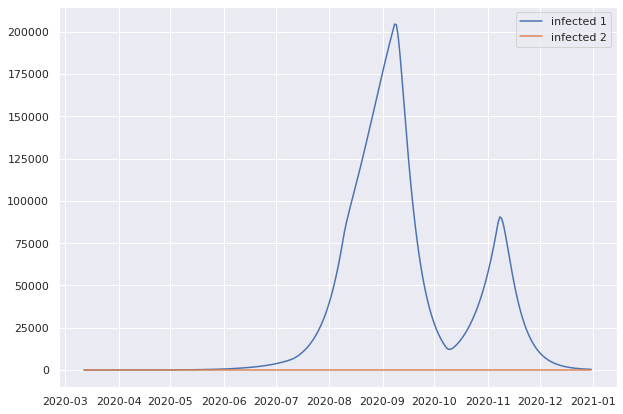

In [356]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, I1, label='infected 1')
# plt.plot(train_subset.date, E1, label='exposed 1')
plt.plot(train_subset.date, I2, label='infected 2')
# plt.plot(train_subset.date, E2, label='exposed 2')
# plt.plot(train_subset.date, D, label='dead')
plt.legend()
plt.show()

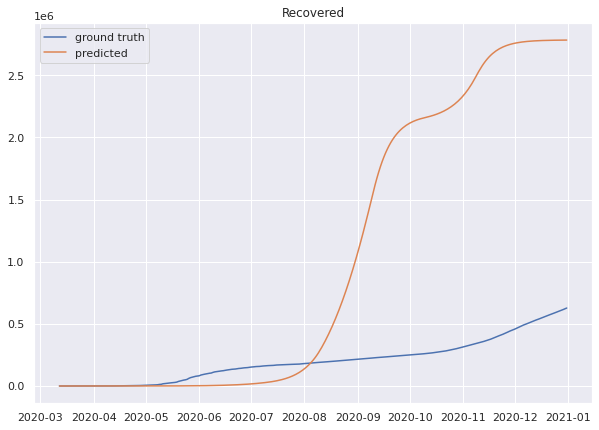

In [357]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_recovered'], label='ground truth')
plt.plot(train_subset.date, R, label='predicted')
plt.legend()
plt.title('Recovered')
plt.show()

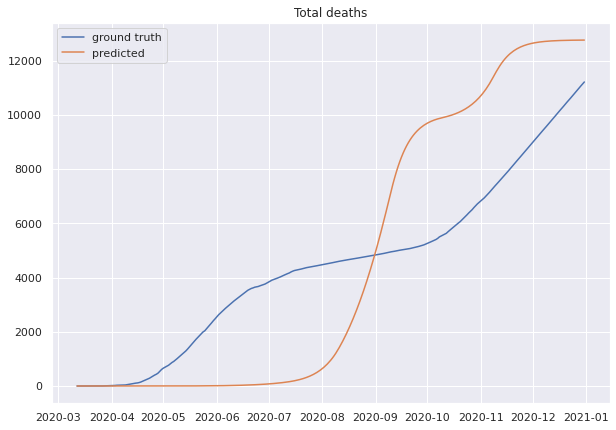

In [358]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_dead'], label='ground truth')
plt.plot(train_subset.date, D, label='predicted')
plt.legend()
plt.title('Total deaths')
plt.show()

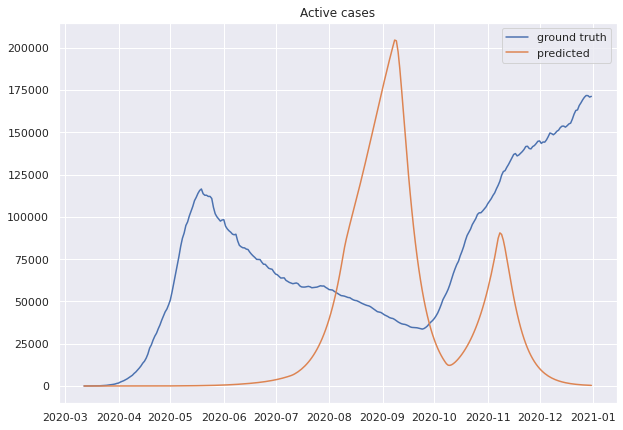

In [359]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['infected'], label='ground truth')
plt.plot(train_subset.date, I1, label='predicted')
plt.legend()
plt.title('Active cases')
plt.show()

# Future forecast

In [360]:
train_t = np.arange(len(train_subset))

In [361]:
future_dates = pd.date_range(start=df.iloc[-1].date, periods=365//2)[1:]
future_t = np.arange(train_t[-1]+1, train_t[-1]+1+len(future_dates))

assert len(future_dates) == len(future_t)

In [362]:
(future_S, future_E1, future_I1, future_E2, future_I2, future_R, future_D), history = model.predict_test(future_t)

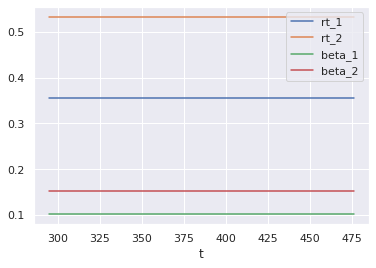

In [363]:
plt.figure()
history.rt_1.plot()
history.rt_2.plot()

history.beta_1.plot()
history.beta_2.plot()
plt.legend()
plt.show()

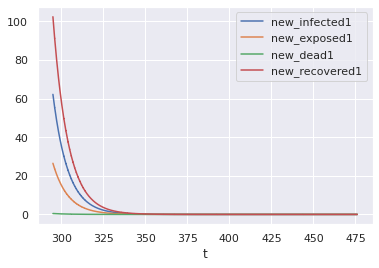

In [364]:
history.new_infected1.plot()
history.new_exposed1.plot()
history.new_dead1.plot()
history.new_recovered1.plot()
plt.legend()

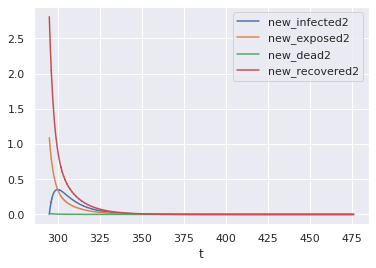

In [365]:
history.new_infected2.plot()
history.new_exposed2.plot()
history.new_dead2.plot()
history.new_recovered2.plot()
plt.legend()

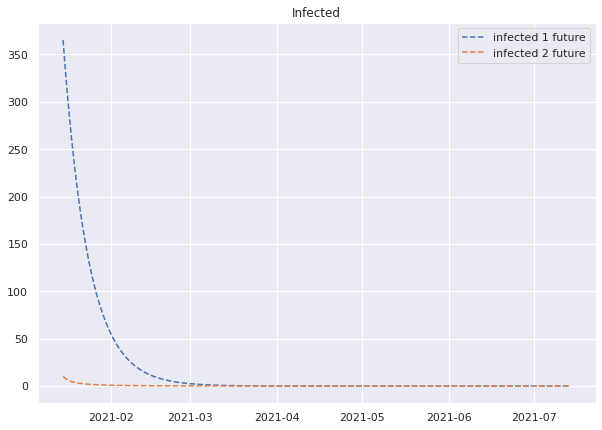

In [366]:
plt.figure(figsize=(10, 7))
plt.plot(future_dates, future_I1, label='infected 1 future', linestyle='--')
plt.plot(future_dates, future_I2, label='infected 2 future', linestyle='--')
plt.legend()
plt.title('Infected')
plt.show()

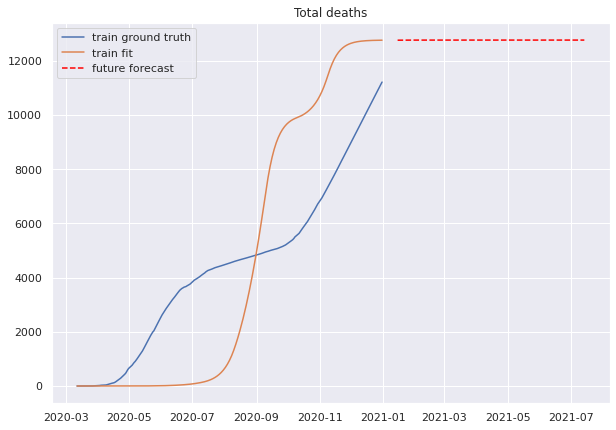

In [367]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_dead'], label='train ground truth')
plt.plot(train_subset.date, D, label='train fit')

plt.plot(future_dates, future_D, label='future forecast', color='red', linestyle='--')
plt.legend()
plt.title('Total deaths')
plt.show()

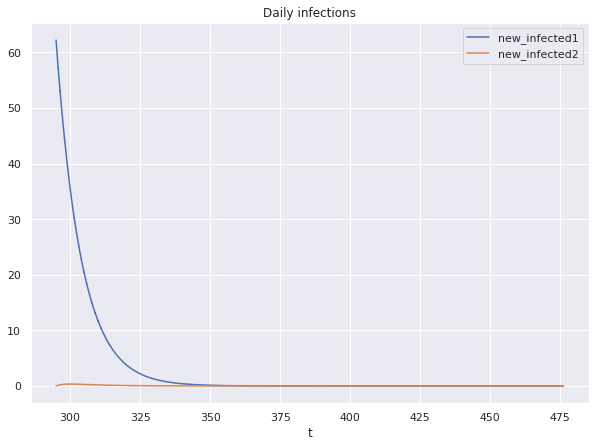

In [368]:
plt.figure(figsize=(10, 7))
history.new_infected1.plot()
history.new_infected2.plot()
plt.legend()
plt.title('Daily infections')
plt.show()